In [26]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import RocCurveDisplay
import datetime

In [3]:
bd = pd.read_csv("TrainAndValid.csv", low_memory = False, parse_dates = ["saledate"])
bd

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,2012-03-07,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,2012-03-07,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [4]:
bd["saleYear"] = bd.saledate.dt.year
bd["saleMonth"] = bd.saledate.dt.month
bd["saleDay"] = bd.saledate.dt.day
bd["saleDayofweek"] = bd.saledate.dt.dayofweek
bd["saleDayofyear"] = bd.saledate.dt.dayofyear

bd.drop("saledate", axis=1, inplace=True)

In [5]:
for label, content in bd.items() :
    if pd.api.types.is_string_dtype(content):
        bd[label] = content.astype("category").cat.as_ordered()
for label, content in bd.items() :
    if pd.api.types.is_object_dtype(content):
        bd[label] = content.astype("category").cat.as_ordered()

In [6]:
bd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [7]:
for label, content in bd.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            bd[label+"_is_missing"] = pd.isnull(content)
            bd[label] = content.fillna(content.median())
        

In [8]:
for label, content in bd.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum:
            bd[label+"_is_missing"] = pd.isnull(content)
            bd[label] = pd.Categorical(content).codes+1
    

In [9]:
bd.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [33]:
val = bd[bd.saleYear == 2012]
train = bd[bd.saleYear != 2012]

X_train, y_train = train.drop("SalePrice", axis=1), train["SalePrice"]
X_valid, y_valid = val.drop("SalePrice", axis=1), val["SalePrice"]

In [34]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def show_scores(model): 
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    
    scores = {"msle" : mean_squared_log_error(y_valid, valid_preds),
             "rmsle" : np.sqrt(mean_squared_log_error(y_valid, valid_preds)),
            "mae" : mean_absolute_error(y_valid, valid_preds),
            "score" : model.score(X_valid, y_valid)}
    return scores

In [36]:
%%time
model = RandomForestRegressor(n_jobs = -1, max_samples = 10000)
model.fit(X_train, y_train)
show_scores(model)

CPU times: total: 21min 47s
Wall time: 3min 31s


{'msle': 0.08567328008380666,
 'rmsle': 0.292699983060824,
 'mae': 7120.5059906679335,
 'score': 0.8348311440715144}

In [39]:
%%time

rs_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1.0, "sqrt"], # Note: "max_features='auto'" is equivalent to "max_features=1.0", as of Scikit-Learn version 1.1
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                         param_distributions=rs_grid,
                         n_iter = 100,
                         cv = 5,
                         verbose = True)

rs_model.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
CPU times: total: 13min 38s
Wall time: 14min 11s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [41]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 16,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [ ]:
%%time

gs_grid = {"n_estimators": [70,80,90],
           "max_depth": [None],
           "min_samples_split": [14,16,18],
           "min_samples_leaf": [7,9,11],
           "max_features": [0.5],
           "max_samples": [10000]}

gs_model = GridSearchCV(RandomForestRegressor(),
                         param_grid=gs_grid,
                         cv = 5,
                         verbose = True)

gs_model.fit(X_train, y_train)

In [44]:
%%time

rs_grid2 = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1.0, "sqrt"], # Note: "max_features='auto'" is equivalent to "max_features=1.0", as of Scikit-Learn version 1.1
           "max_samples": [10000]}

rs_model2 = RandomizedSearchCV(RandomForestRegressor(),
                         param_distributions=rs_grid2,
                         n_iter = 100,
                         cv = 5,
                         verbose = True)

rs_model2.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 1h 47min 19s
Wall time: 2h 3min 7s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [46]:
rs_model2.best_params_

{'n_estimators': 50,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [47]:
show_scores(rs_model2)

{'msle': 0.08976256033876777,
 'rmsle': 0.2996040058790399,
 'mae': 7415.377492290797,
 'score': 0.8197142465895022}

In [56]:
test = pd.read_csv("Test.csv", low_memory = False, parse_dates = ["saledate"])


def data_modeling(df) :
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    df.drop("saledate", axis=1, inplace=True)  
    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
            
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
        
    for label, content in df.items():
        if pd.api.types.is_object_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
        
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum:
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = pd.Categorical(content).codes+1
    return df

In [57]:
data_modeling(test)
test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [58]:
X_train

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1139246,999089,3157,121,3.0,2004,68.0,2,963,298,...,True,True,True,True,True,True,True,True,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1745,529,...,True,True,True,True,True,True,True,True,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,336,111,...,True,True,True,True,True,True,True,True,True,True
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3716,1381,...,True,True,True,True,True,True,True,True,True,True
4,1139253,1057373,17311,121,3.0,2007,722.0,3,4261,1538,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,1840702,21439,149,1.0,2005,0.0,0,666,209,...,False,False,False,False,False,True,True,True,True,True
401121,6333337,1830472,21439,149,1.0,2005,0.0,0,666,209,...,False,False,False,False,False,True,True,True,True,True
401122,6333338,1887659,21439,149,1.0,2005,0.0,0,666,209,...,False,False,False,False,False,True,True,True,True,True
401123,6333341,1903570,21435,149,2.0,2005,0.0,0,490,160,...,False,False,False,False,False,True,True,True,True,True


In [59]:
set(X_train.columns) - set(test.columns)

{'auctioneerID_is_missing'}

In [62]:
test["auctioneerID_is_missing"] = False
test = test.reindex(columns=list(X_train.columns))
test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [63]:
preds = model.predict(test)

In [65]:
final = pd.DataFrame()
final["SalesID"] = test["SalesID"]
final["Predicted_Price"] = preds
final

,SalesID,Predicted_Price
0,1227829,18819.5
1,1227844,23527.5
2,1227847,49645.0
3,1227848,77690.0
4,1227863,43162.0
...,...,...
12452,6643171,47325.0
12453,6643173,12458.0
12454,6643184,12920.0
12455,6643186,16087.0


In [67]:
model.feature_importances_

array([4.86909436e-02, 2.25405996e-02, 2.87786165e-02, 1.04708522e-03,
       5.95090220e-03, 2.54479653e-01, 4.39817190e-03, 1.47110149e-03,
       2.13385614e-02, 4.84921014e-02, 5.70629973e-02, 4.10366911e-03,
       4.36738876e-03, 2.25200469e-01, 3.19580016e-02, 1.14295693e-02,
       1.15340394e-03, 1.40324349e-03, 1.47154125e-03, 1.70722856e-02,
       6.05469763e-04, 6.35053076e-05, 1.22233304e-03, 2.08096814e-04,
       1.16980039e-03, 3.98962423e-05, 1.56420297e-03, 2.29064217e-02,
       8.65596444e-04, 8.98068336e-04, 4.16143406e-03, 3.06843885e-03,
       3.48945708e-03, 2.53765727e-03, 1.13592530e-03, 2.92369235e-03,
       1.40811563e-03, 1.19456856e-02, 8.65319372e-04, 5.73907102e-04,
       3.16608987e-04, 1.20441801e-03, 1.65918488e-03, 9.18841570e-04,
       7.13731718e-04, 8.94202560e-04, 1.71203649e-04, 2.70886712e-03,
       1.15169173e-03, 2.21035686e-04, 1.81085481e-04, 6.50242783e-02,
       4.69467058e-03, 1.26139070e-02, 6.23032558e-03, 1.38653858e-02,
      

In [69]:
import seaborn as sns

def plot_features(columns, feature_importance):
    graph = pd.DataFrame({"Features" : columns, "Feature Importance" : feature_importance}).sort_values("Feature Importance", ascending = False).reset_index(drop=True)
    sns.barplot(x = "Feature Importance", y = "Features", data = graph[:20], orient="h" )


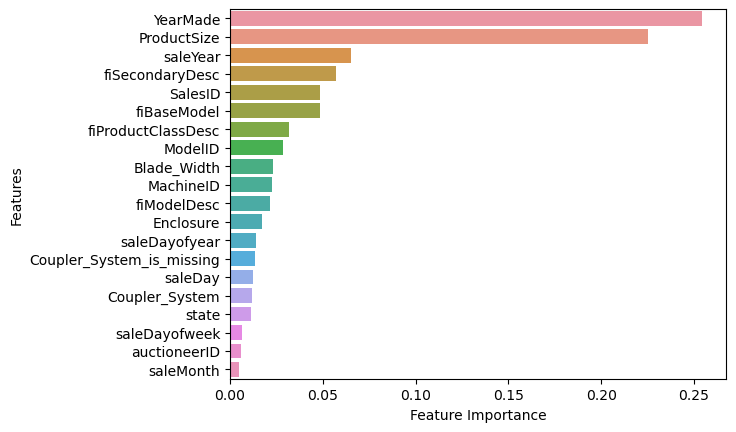

In [70]:
plot_features(X_train.columns, model.feature_importances_)

In [71]:
final.to_csv("Bull_Dozer_Predictions.csv", index=False)

In [72]:
pd.read_csv("Bull_Dozer_Predictions.csv")

,SalesID,Predicted_Price
0,1227829,18819.5
1,1227844,23527.5
2,1227847,49645.0
3,1227848,77690.0
4,1227863,43162.0
...,...,...
12452,6643171,47325.0
12453,6643173,12458.0
12454,6643184,12920.0
12455,6643186,16087.0


In [ ]:
plt.subplot()